In [1]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification
)
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt

In [3]:
MODEL_NAME   = "bert-base-uncased"
MAX_LEN      = 128
NUM_LABELS    = 3
BATCH_SIZE   = 8
# LR           = 3e-5
NUM_EPOCHS   = 3
OUTPUT_DIR   = "./bert_token_classification"
RANDOM_STATE = 42

In [4]:
label_list = ["O", "B", "I"]
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for l, i in label2id.items()}

In [5]:
train_data = pd.read_csv("/content/train.csv").fillna("")
test_data = pd.read_csv("/content/test.csv").fillna("")

In [6]:
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [7]:
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [8]:
pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=256092e23392a24a9440945c2f1d976b3510af57fa3a8ba09fcbc4887dcd2905
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [9]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
metric = evaluate.load("seqeval")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [10]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data.sentiment)

In [11]:
print("size of train - ",train_data.size)
print("size of val - ",val_data.size)

size of train -  87936
size of val -  21988


# **Baseline Model**

In [12]:
def baseline_prediction(row):
    text = row["text"]
    sentiment = row["sentiment"].lower()

    if sentiment == "neutral":
        return text

    words = text.strip().split()
    if len(words) <= 2:
        return text
    else:
        start = len(words) // 3
        end = 2 * len(words) // 3
        return " ".join(words[start:end])

In [14]:
val_data["selected_text_baseline"] = val_data.apply(baseline_prediction, axis=1)
val_data[["text", "sentiment", "selected_text_baseline"]].to_csv("/content/outputs/baseline_predictions.csv", index=False)

In [15]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    if not a and not b:
        return 1.0
    return len(a & b) / len(a | b)

jaccard_scores = []
for i, row in val_data.iterrows():
    score = jaccard(row["selected_text"], row["selected_text_baseline"])
    jaccard_scores.append(score)

baseline_jaccard = np.mean(jaccard_scores)
print(f"Baseline Jaccard Score: {baseline_jaccard:.4f}")
print(f"Baseline Loss (1 - Jaccard): {1 - baseline_jaccard:.4f}")
print(f"Baseline Accuracy (Jaccard > 0.5): {(np.mean([j >= 0.5 for j in jaccard_scores])):.4f}")

Baseline Jaccard Score: 0.4998
Baseline Loss (1 - Jaccard): 0.5002
Baseline Accuracy (Jaccard > 0.5): 0.4623


# **Bert Model**

In [16]:
# metric = evaluate.load("squad")
def encode_tags(text, selected_text):
    tags = ["O"] * len(text)
    if selected_text:
        start = text.find(selected_text)
        if start != -1:
            for i in range(start, start + len(selected_text)):
                tags[i] = "I"
            tags[start] = "B"
    return tags


def tokenize_and_align_labels(examples):
    tokenized = tokenizer(
        examples["text"],
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_offsets_mapping=True
    )
    labels = []
    for i, offsets in enumerate(tokenized["offset_mapping"]):
        tag_seq = encode_tags(examples["text"][i], examples.get("selected_text", [""])[i])
        label = []
        for offset in offsets:
            if offset[0] == offset[1]:
                label.append(-100)
            else:
                tag = tag_seq[offset[0]:offset[1]]
                if tag:
                    label.append(label2id[max(tag, key=tag.count)])
                else:
                    label.append(label2id["O"])
        labels.append(label)

    tokenized["labels"] = labels
    tokenized.pop("offset_mapping")
    return tokenized


In [17]:
train_ds = Dataset.from_pandas(train_data.reset_index(drop=True)).map(tokenize_and_align_labels, batched=True)
val_ds = Dataset.from_pandas(val_data.reset_index(drop=True)).map(tokenize_and_align_labels, batched=True)
test_ds  = Dataset.from_pandas(test_data.reset_index(drop=True)).map(
    lambda examples: tokenizer(
        examples["text"],
        max_length=MAX_LEN,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ), batched=True
)

Map:   0%|          | 0/21984 [00:00<?, ? examples/s]

Map:   0%|          | 0/5497 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [18]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=id2label,
    label2id=label2id
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
data_collator = DataCollatorForTokenClassification(tokenizer)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)
    labels = p.label_ids

    true_preds, true_labels = [], []
    for pred, label in zip(preds, labels):
        cur_preds, cur_labels = [], []
        for p_, l_ in zip(pred, label):
            if l_ != -100:
                cur_preds.append(id2label[p_])
                cur_labels.append(id2label[l_])
        true_preds.append(cur_preds)
        true_labels.append(cur_labels)

    return metric.compute(predictions=true_preds, references=true_labels)

In [20]:
training_args = TrainingArguments(

    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    logging_dir=f"{OUTPUT_DIR}/logs",
    load_best_model_at_end=True,
    save_strategy="epoch",
    metric_for_best_model="eval_overall_f1",
    lr_scheduler_type="linear",
    warmup_steps=0,
    report_to="none"
)


In [21]:
from transformers import EarlyStoppingCallback

trainer = Trainer(

    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

<ipython-input-21-63193ca2ee62>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
train_losses = []
eval_losses = []
eval_f1s = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    trainer.train()

    eval_result = trainer.evaluate()
    train_loss = trainer.state.log_history[-2].get("loss", None)
    eval_loss = eval_result["eval_loss"]
    eval_f1 = eval_result.get("eval_overall_f1", 0)

    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    eval_f1s.append(eval_f1)


Epoch 1/3


Epoch,Training Loss,Validation Loss,,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.569700,0.564735,"{'precision': 0.31614319023453574, 'recall': 0.4193196288884846, 'f1': 0.36049421332499215, 'number': 5497}",0.316143,0.419320,0.360494,0.720344
2,0.475200,0.583773,"{'precision': 0.33743560389238697, 'recall': 0.42896125159177734, 'f1': 0.37773327993592315, 'number': 5497}",0.337436,0.428961,0.377733,0.714393
3,0.354200,0.737320,"{'precision': 0.3533432392273403, 'recall': 0.4325995997816991, 'f1': 0.38897521877811403, 'number': 5497}",0.353343,0.432600,0.388975,0.718957



Epoch 2/3


Epoch,Training Loss,Validation Loss,,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.374000,0.766812,"{'precision': 0.3506224066390041, 'recall': 0.43041659086774603, 'f1': 0.3864434463046141, 'number': 5497}",0.350622,0.430417,0.386443,0.715898
2,0.278700,0.845715,"{'precision': 0.3591560141691052, 'recall': 0.42423139894487905, 'f1': 0.3889908256880734, 'number': 5497}",0.359156,0.424231,0.388991,0.708999
3,0.190100,1.037590,"{'precision': 0.3550268610897928, 'recall': 0.4207749681644533, 'f1': 0.3851148851148851, 'number': 5497}",0.355027,0.420775,0.385115,0.710729



Epoch 3/3


Epoch,Training Loss,Validation Loss,,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.241400,0.947357,"{'precision': 0.3503727369542066, 'recall': 0.41895579406949246, 'f1': 0.3816072908036454, 'number': 5497}",0.350373,0.418956,0.381607,0.697253
2,0.184400,0.987336,"{'precision': 0.3683794466403162, 'recall': 0.42386756412588683, 'f1': 0.3941803417357469, 'number': 5497}",0.368379,0.423868,0.394180,0.705354
3,0.120400,1.262584,"{'precision': 0.3602677876381753, 'recall': 0.42095688557394945, 'f1': 0.388255033557047, 'number': 5497}",0.360268,0.420957,0.388255,0.709292


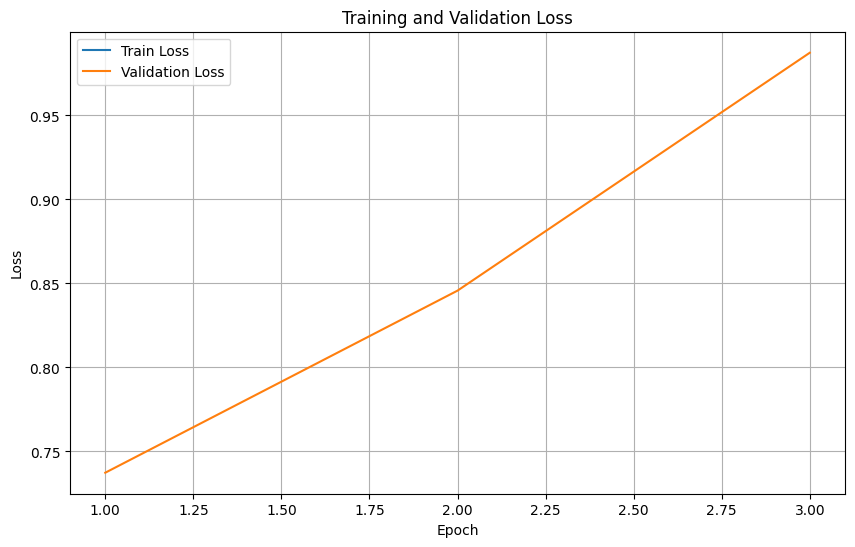

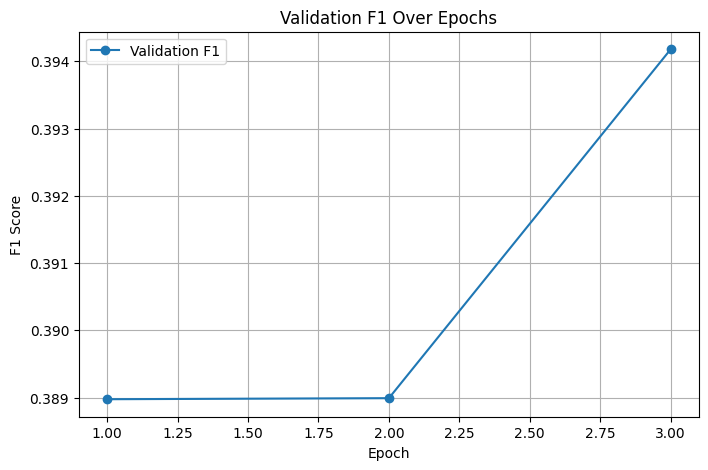

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, NUM_EPOCHS + 1), eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(range(1, NUM_EPOCHS + 1), eval_f1s, marker='o', label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Over Epochs")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:

def extract_selected_text(text, tokens, labels):
    words = tokenizer.convert_ids_to_tokens(tokens, skip_special_tokens=True)
    selected = []
    for word, label in zip(words, labels):
        if label == label2id["B"] or (label == label2id["I"] and selected):
            selected.append(word)
    return tokenizer.convert_tokens_to_string(selected)

In [25]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    if not a and not b:
        return 1.0
    return len(a & b) / len(a | b)

val_preds = trainer.predict(val_ds).predictions
val_pred_labels = np.argmax(val_preds, axis=2)
val_selected = []
for i in range(len(val_data)):
    tokens = val_ds[i]["input_ids"]
    labels = val_pred_labels[i]
    text = val_data.iloc[i]["text"]
    selected = extract_selected_text(text, tokens, labels)
    val_selected.append(selected)

val_data["selected_text_pred"] = val_selected
jaccard_scores_model = [jaccard(true, pred) for true, pred in zip(val_data["selected_text"], val_data["selected_text_pred"])]
model_jaccard = np.mean(jaccard_scores_model)
print(f"Model Jaccard Score on Validation Set: {model_jaccard:.4f}")

Model Jaccard Score on Validation Set: 0.1253


# **Deberta Model**

In [ ]:
MODEL_NAME   = "microsoft/deberta-v3-large"
MAX_LEN      = 128
BATCH_SIZE   = 8
LR           = 3e-5
NUM_EPOCHS   = 3
OUTPUT_DIR   = "./output_span_model"
RANDOM_STATE = 42

In [ ]:
df = pd.read_csv("/content/train.csv").fillna("")
train_df, val_df = train_test_split(df, test_size=0.1, random_state=RANDOM_STATE, stratify=df.sentiment)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True))

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def preprocess_batch(examples):
    inputs  = examples["sentiment"]
    texts   = examples["text"]
    spans   = examples["selected_text"]

    enc = tokenizer(
        inputs,
        texts,
        max_length=MAX_LEN,
        padding="max_length",
        truncation="only_second",
        return_offsets_mapping=True,
    )

    start_positions = []
    end_positions   = []

    for i, offsets in enumerate(enc.pop("offset_mapping")):
        text   = texts[i]
        span   = spans[i]
        start_char = text.find(span)
        end_char   = start_char + len(span)

        s_tok = e_tok = 0
        for idx, (s_off, e_off) in enumerate(offsets):
            if s_off <= start_char < e_off:
                s_tok = idx
            if s_off < end_char <= e_off:
                e_tok = idx
        start_positions.append(s_tok)
        end_positions.append(e_tok)

    enc["start_positions"] = start_positions
    enc["end_positions"]   = end_positions
    return enc

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
train_ds = train_ds.map(preprocess_batch, batched=True, remove_columns=train_ds.column_names)
val_ds   = val_ds.map(preprocess_batch, batched=True, remove_columns=val_ds.column_names)

model = AutoModelForQuestionAnswering.from_pretrained(MODEL_NAME)

data_collator = DataCollatorWithPadding(tokenizer)

Map:   0%|          | 0/24732 [00:00<?, ? examples/s]

Map:   0%|          | 0/2749 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForQuestionAnswering were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric = evaluate.load("squad")

def compute_metrics(p):
    start_preds, end_preds = p.predictions
    start_preds = np.argmax(start_preds, axis=1)
    end_preds = np.argmax(end_preds, axis=1)

    predictions = []
    references = []

    for i in range(len(start_preds)):
        input_ids = val_ds[i]["input_ids"]
        start = start_preds[i]
        end = end_preds[i]

        if start > end or end >= len(input_ids):
            pred_text = ""
        else:
            pred_tokens = input_ids[start:end+1]
            pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)

        predictions.append({
            "id": str(i),
            "prediction_text": pred_text.strip(),
        })

        true_text = val_df.iloc[i]["selected_text"]
        true_start = val_df.iloc[i]["text"].find(true_text)

        references.append({
            "id": str(i),
            "answers": {
                "text": [true_text],
                "answer_start": [true_start]
            }
        })

    res = metric.compute(predictions=predictions, references=references)
    return {"exact_match": res["exact_match"], "f1": res["f1"]}

In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir=f"{OUTPUT_DIR}/logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="epoch",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

trainer.train()

<ipython-input-8-2c5ca864e9f2>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Exact Match,F1
1,0.857300,0.983023,56.857039,74.317837
2,0.669500,0.832263,59.112405,77.132160
3,0.469800,1.030141,57.620953,76.593210


TrainOutput(global_step=9276, training_loss=0.708042685560956, metrics={'train_runtime': 8850.9244, 'train_samples_per_second': 8.383, 'train_steps_per_second': 1.048, 'total_flos': 1.7226702697199616e+16, 'train_loss': 0.708042685560956, 'epoch': 3.0})

In [ ]:
def calculate_jaccard(true_texts, pred_texts):
    jaccard_scores = []
    for true, pred in zip(true_texts, pred_texts):
        true_set = set(true.lower().split())
        pred_set = set(pred.lower().split())
        if len(true_set.union(pred_set)) == 0:
            jaccard_scores.append(1.0)
        else:
            jaccard_scores.append(len(true_set.intersection(pred_set)) / len(true_set.union(pred_set)))
    return np.mean(jaccard_scores)

import numpy as np

def calculate_jaccard(true_texts, pred_texts):
    jaccard_scores = []
    for true, pred in zip(true_texts, pred_texts):
        true_set = set(true.lower().split())
        pred_set = set(pred.lower().split())
        if len(true_set.union(pred_set)) == 0:
            jaccard_scores.append(1.0)
        else:
            jaccard_scores.append(len(true_set.intersection(pred_set)) / len(true_set.union(pred_set)))
    return np.mean(jaccard_scores)


def calculate_accuracy(true_texts, pred_texts):
    correct = sum(1 for true, pred in zip(true_texts, pred_texts) if true.lower() == pred.lower())
    return correct / len(true_texts)

In [ ]:
predictions = trainer.predict(val_ds)
start_preds, end_preds = predictions.predictions
start_preds = np.argmax(start_preds, axis=1)
end_preds = np.argmax(end_preds, axis=1)

pred_texts = []
true_texts = val_df["selected_text"].tolist()

for i in range(len(start_preds)):
    input_ids = val_ds[i]["input_ids"]
    start = start_preds[i]
    end = end_preds[i]

    if start > end or end >= len(input_ids):
        pred_texts.append("")
    else:
        pred_tokens = input_ids[start:end+1]
        pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
        pred_texts.append(pred_text.strip())

In [ ]:
jaccard = calculate_jaccard(true_texts, pred_texts)
accuracy = calculate_accuracy(true_texts, pred_texts)
loss = predictions.metrics["test_loss"]

print(f"Jaccard Similarity: {jaccard:.4f}")
print(f"Accuracy (Exact Match): {accuracy:.4f}")
print(f"Loss: {loss:.4f}")

Jaccard Similarity: 0.7149
Accuracy (Exact Match): 0.4827
Loss: 0.8323


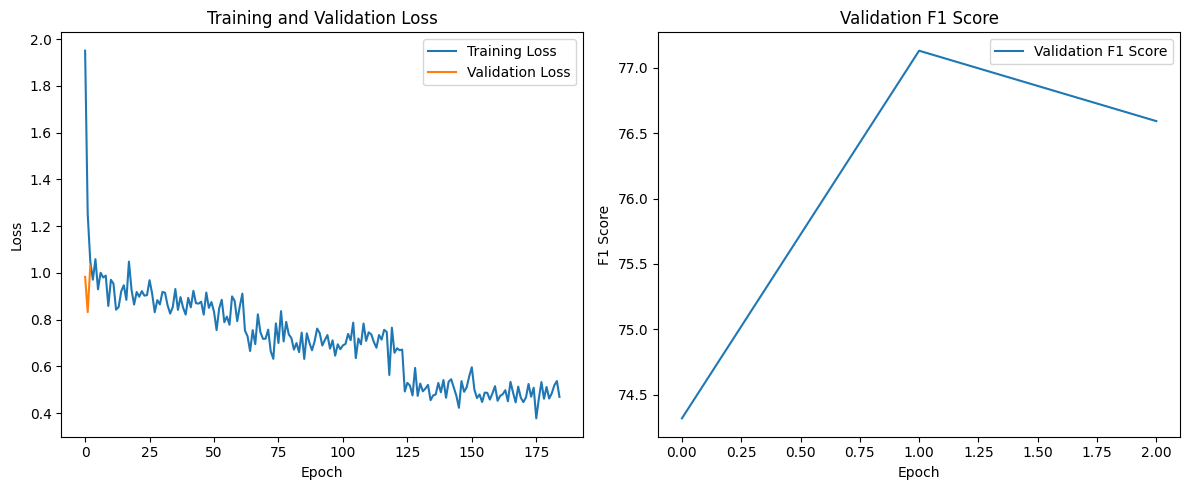

In [ ]:
import matplotlib.pyplot as plt

history = trainer.state.log_history

train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(eval_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(eval_f1, label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# **Test Data**

In [ ]:
test_df = pd.read_csv("/content/test.csv").fillna("")

test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))

In [ ]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["sentiment"],
        examples["text"],
        max_length=MAX_LEN,
        padding="max_length",
        truncation="only_second",
        return_offsets_mapping=True
    )

test_ds = test_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

In [ ]:
predictions = trainer.predict(test_ds)
start_preds = np.argmax(predictions.predictions[0], axis=1)
end_preds = np.argmax(predictions.predictions[1], axis=1)

predicted_texts = []
for i, (start, end) in enumerate(zip(start_preds, end_preds)):
    offsets = test_ds[i]["offset_mapping"]
    if start >= len(offsets) or end >= len(offsets) or start > end:
        predicted_texts.append("")
    else:
        start_char = offsets[start][0]
        end_char = offsets[end][1]
        predicted_texts.append(test_df.iloc[i]["text"][start_char:end_char].strip())

output_df = pd.DataFrame({
    "textID": test_df["textID"],
    "selected_text": predicted_texts
})

output_path = "/content/outputs/outputs.csv"
output_df.to_csv(output_path, index=False)